In [114]:
import sys

In [115]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [174]:
CONVERTED_DATABASE_NAME = 'Hela_20A_20R_500'
FEATURES_DATABASE = '/Volumes/Samsung_T5/databases/Hela_20A_20R_500-features.sqlite'
SUMMED_REGIONS_DATABASE = '/Volumes/Samsung_T5/databases/Hela_20A_20R_500-features-1-100000-random-1000-sf-1000.sqlite'

In [117]:
def standard_deviation(mz):
    instrument_resolution = 40000.0
    return ((mz / instrument_resolution) / 2.35482)

In [118]:
src_conn_2 = sqlite3.connect(SUMMED_REGIONS_DATABASE)

feature_ids_df = pd.read_sql_query("select distinct(feature_id) from peak_correlation", src_conn_2)

src_conn_2.close()

In [119]:
# pick 20 feature IDs from the collection
random_feature_indexes = random.sample(range(len(feature_ids_df)), 20)
feature_ids_df = feature_ids_df.iloc[random_feature_indexes]
feature_ids_df.sort_values(by='feature_id', inplace=True)
feature_ids_df

,feature_id
21,2560
87,9800
112,12036
148,16086
252,26137
255,26669
261,26934
314,33369
326,34582
463,47769


In [120]:
FEATURE_ID = 53359

In [121]:
src_conn = sqlite3.connect(FEATURES_DATABASE)

feature_df = pd.read_sql_query("select * from features where feature_id = {}".format(FEATURE_ID), src_conn)
charge_state = feature_df.loc[0].charge_state.astype(int)

src_conn.close()

In [221]:
feature_df

,feature_id,base_frame_id,base_cluster_id,charge_state,start_frame,end_frame,quality_score,summed_intensity,scan_lower,scan_upper,mz_lower,mz_upper
0,53359,1416,205,2,1406,1429,1.0,632901,142,157,467.257751,469.746613


In [122]:
src_conn_2 = sqlite3.connect(SUMMED_REGIONS_DATABASE)

peaks_df = pd.read_sql_query("select * from summed_ms1_regions where feature_id = {} order by peak_id".format(FEATURE_ID), src_conn_2)

src_conn_2.close()

In [123]:
MINIMUM_CORRELATION = 0.6
src_conn_2 = sqlite3.connect(SUMMED_REGIONS_DATABASE)

ms2_peaks_df = pd.read_sql_query("select * from ms2_peaks where (feature_id,peak_id) in (select feature_id,ms2_peak_id from peak_correlation where feature_id={} and correlation > {})".format(FEATURE_ID, MINIMUM_CORRELATION), src_conn_2)

src_conn_2.close()

In [222]:
len(ms2_peaks_df)

3538

In [124]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

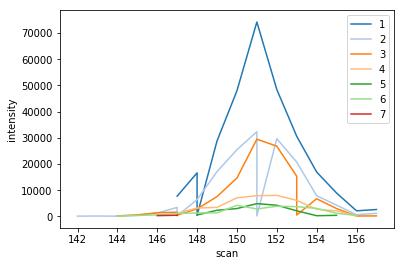

In [125]:
fig, ax = plt.subplots()
groups = peaks_df.groupby('peak_id')
for i, (name, group) in enumerate(groups):
    ax.plot(group.scan, group.intensity, color=tableau20[i], label=name)
plt.legend(loc='best')
plt.xlabel('scan')
plt.ylabel('intensity')
plt.margins(0.06)
plt.show()

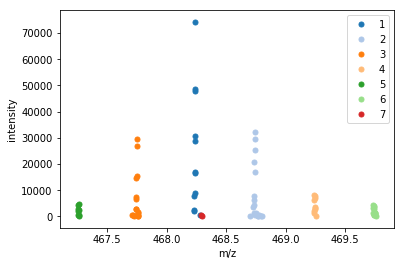

In [126]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
groups = peaks_df.groupby('peak_id')
for i, (name, group) in enumerate(groups):
    ax.plot(group.mz, group.intensity, marker='o', color=tableau20[i], linestyle='', ms=5, label=name)
plt.legend(loc='best')
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.margins(0.06)
plt.show()

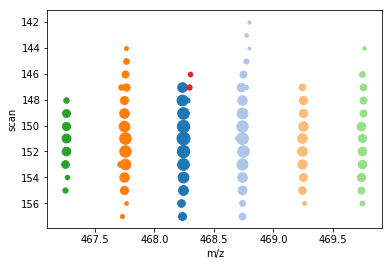

In [127]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
groups = peaks_df.groupby('peak_id')
for i, (name, group) in enumerate(groups):
    for data_point in group.itertuples():
        markersize = 10+1.5*np.log(data_point.intensity*0.0001)
        ax.plot(data_point.mz, data_point.scan, marker='o', color=tableau20[i], linestyle='', markersize=markersize, label=name)
# plt.legend(loc='best')
plt.xlabel('m/z')
plt.ylabel('scan')
plt.gca().invert_yaxis()
plt.margins(0.06)
plt.show()

In [128]:
def wavg(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [129]:
mzs = peaks_df.groupby('peak_id').apply(wavg, "mz", "intensity").reset_index(name='mz_centroid')

In [130]:
mzs

,peak_id,mz_centroid
0,1,468.240632
1,2,468.739658
2,3,467.749297
3,4,469.243980
4,5,467.258185
5,6,469.740474
6,7,468.291738


In [131]:
intensities = peaks_df.groupby('peak_id').intensity.sum().reset_index(name='summed_intensity')

In [132]:
intensities

,peak_id,summed_intensity
0,1,285440
1,2,151536
2,3,111599
3,4,41969
4,5,17848
5,6,23782
6,7,727


In [133]:
cluster_df = pd.concat([mzs, intensities.summed_intensity], axis=1)

In [134]:
cluster_df

,peak_id,mz_centroid,summed_intensity
0,1,468.240632,285440
1,2,468.739658,151536
2,3,467.749297,111599
3,4,469.243980,41969
4,5,467.258185,17848
5,6,469.740474,23782
6,7,468.291738,727


In [135]:
cluster_df.sort_values(by='mz_centroid', inplace=True)

In [136]:
cluster_df

,peak_id,mz_centroid,summed_intensity
4,5,467.258185,17848
2,3,467.749297,111599
0,1,468.240632,285440
6,7,468.291738,727
1,2,468.739658,151536
3,4,469.243980,41969
5,6,469.740474,23782


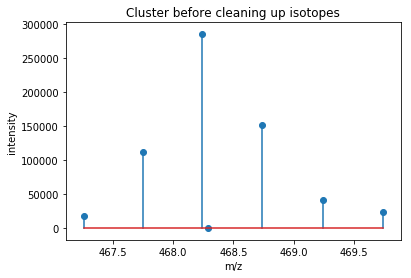

In [137]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.stem(cluster_df.mz_centroid, cluster_df.summed_intensity)
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.margins(0.06)
plt.title('Cluster before cleaning up isotopes')
plt.show()

In [138]:
cluster_df.reset_index(drop=True, inplace=True)
base_peak_index = cluster_df.summed_intensity.idxmax()
cluster_df

,peak_id,mz_centroid,summed_intensity
0,5,467.258185,17848
1,3,467.749297,111599
2,1,468.240632,285440
3,7,468.291738,727
4,2,468.739658,151536
5,4,469.243980,41969
6,6,469.740474,23782


In [139]:
DELTA_MZ = 1.003355     # Mass difference between Carbon-12 and Carbon-13 isotopes, in Da. For calculating the spacing between isotopic peaks.
PROTON_MASS = 1.007276  # Mass of a proton in unified atomic mass units, or Da. For calculating the monoisotopic mass.

In [140]:
expected_spacing = DELTA_MZ / charge_state
expected_spacing

0.5016775

In [141]:
base_peak_mz = cluster_df.iloc[base_peak_index].mz_centroid
spacing_from_base = abs(cluster_df.mz_centroid - base_peak_mz) % expected_spacing
spacing_from_base

0    0.480770
1    0.491336
2    0.000000
3    0.051105
4    0.499025
5    0.501670
6    0.496486
Name: mz_centroid, dtype: float64

In [142]:
base_peak_mz

468.2406324341153

In [143]:
# drop indices that are not within 4*stddev of an isotope
std_dev = standard_deviation(base_peak_mz)
close_to_next_isotope = (abs(spacing_from_base - expected_spacing) < (standard_deviation(base_peak_mz) * 4))
close_to_next_isotope

0    False
1     True
2    False
3    False
4     True
5     True
6     True
Name: mz_centroid, dtype: bool

In [144]:
close_to_this_isotope = spacing_from_base < (standard_deviation(base_peak_mz) * 4)
close_to_this_isotope

0    False
1    False
2     True
3    False
4    False
5    False
6    False
Name: mz_centroid, dtype: bool

In [145]:
indexes_to_drop = ~(close_to_next_isotope | close_to_this_isotope)
indexes_to_drop

0     True
1    False
2    False
3     True
4    False
5    False
6    False
Name: mz_centroid, dtype: bool

In [146]:
cluster_df.drop(cluster_df.index[indexes_to_drop], inplace=True)
cluster_df.reset_index(drop=True, inplace=True)

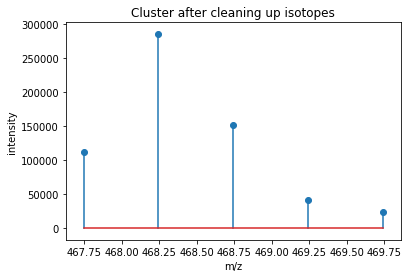

In [147]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.stem(cluster_df.mz_centroid, cluster_df.summed_intensity)
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.margins(0.06)
plt.title('Cluster after cleaning up isotopes')
plt.show()

In [148]:
base_peak_index = cluster_df.summed_intensity.idxmax()
base_peak_mz = cluster_df.iloc[base_peak_index].mz_centroid

In [149]:
indexes_to_drop = abs(cluster_df.mz_centroid.diff() - expected_spacing) > 0.5
indexes_to_drop

0    False
1    False
2    False
3    False
4    False
Name: mz_centroid, dtype: bool

In [150]:
cluster_df.drop(cluster_df.index[indexes_to_drop], inplace=True)
cluster_df.reset_index(drop=True, inplace=True)

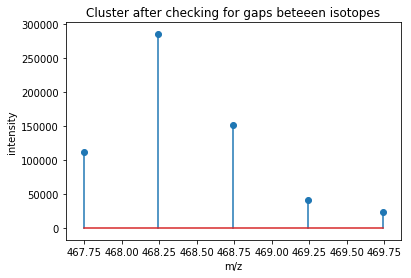

In [151]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.stem(cluster_df.mz_centroid, cluster_df.summed_intensity)
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.margins(0.06)
plt.title('Cluster after checking for gaps beteeen isotopes')
plt.show()

In [152]:
# From "A Model-Based Method for the Prediction of the Isotopic Distribution of Peptides", Dirk Valkenborg, 
# Ivy Jansen, and Tomasz Burzykowski, J Am Soc Mass Spectrom 2008, 19, 703–712

MAX_NUMBER_OF_SULPHUR_ATOMS = 3
MAX_NUMBER_OF_PREDICTED_RATIOS = 6

S0_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=object)
S0_r[1] = [-0.00142320578040, 0.53158267080224, 0.00572776591574, -0.00040226083326, -0.00007968737684]
S0_r[2] = [0.06258138406507, 0.24252967352808, 0.01729736525102, -0.00427641490976, 0.00038011211412]
S0_r[3] = [0.03092092306220, 0.22353930450345, -0.02630395501009, 0.00728183023772, -0.00073155573939]
S0_r[4] = [-0.02490747037406, 0.26363266501679, -0.07330346656184, 0.01876886839392, -0.00176688757979]
S0_r[5] = [-0.19423148776489, 0.45952477474223, -0.18163820209523, 0.04173579115885, -0.00355426505742]
S0_r[6] = [0.04574408690798, -0.05092121193598, 0.13874539944789, -0.04344815868749, 0.00449747222180]

S1_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=object)
S1_r[1] = [-0.01040584267474, 0.53121149663696, 0.00576913817747, -0.00039325152252, -0.00007954180489]
S1_r[2] = [0.37339166598255, -0.15814640001919, 0.24085046064819, -0.06068695741919, 0.00563606634601]
S1_r[3] = [0.06969331604484, 0.28154425636993, -0.08121643989151, 0.02372741957255, -0.00238998426027]
S1_r[4] = [0.04462649178239, 0.23204790123388, -0.06083969521863, 0.01564282892512, -0.00145145206815]
S1_r[5] = [-0.20727547407753, 0.53536509500863, -0.22521649838170, 0.05180965157326, -0.00439750995163]
S1_r[6] = [0.27169670700251, -0.37192045082925, 0.31939855191976, -0.08668833166842, 0.00822975581940]

S2_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=object)
S2_r[1] = [-0.01937823810470, 0.53084210514216, 0.00580573751882, -0.00038281138203, -0.00007958217070]
S2_r[2] = [0.68496829280011, -0.54558176102022, 0.44926662609767, -0.11154849560657, 0.01023294598884]
S2_r[3] = [0.04215807391059, 0.40434195078925, -0.15884974959493, 0.04319968814535, -0.00413693825139]
S2_r[4] = [0.14015578207913, 0.14407679007180, -0.01310480312503, 0.00362292256563, -0.00034189078786]
S2_r[5] = [-0.02549241716294, 0.32153542852101, -0.11409513283836, 0.02617210469576, -0.00221816103608]
S2_r[6] = [-0.14490868030324, 0.33629928307361, -0.08223564735018, 0.01023410734015, -0.00027717589598]

model_params = np.empty(MAX_NUMBER_OF_SULPHUR_ATOMS, dtype=object)
model_params[0] = S0_r
model_params[1] = S1_r
model_params[2] = S2_r

# Find the ratio of H(peak_number)/H(peak_number-1) for peak_number=1..6
# peak_number = 0 refers to the monoisotopic peak
# number_of_sulphur = number of sulphur atoms in the molecule
def peak_ratio(monoisotopic_mass, peak_number, number_of_sulphur):
    ratio = 0.0
    if (((1 <= peak_number <= 3) & (((number_of_sulphur == 0) & (498 <= monoisotopic_mass <= 3915)) |
                                    ((number_of_sulphur == 1) & (530 <= monoisotopic_mass <= 3947)) |
                                    ((number_of_sulphur == 2) & (562 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 4) & (((number_of_sulphur == 0) & (907 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (939 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (971 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 5) & (((number_of_sulphur == 0) & (1219 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (1251 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (1283 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 6) & (((number_of_sulphur == 0) & (1559 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (1591 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (1623 <= monoisotopic_mass <= 3978))))):
        beta0 = model_params[number_of_sulphur][peak_number][0]
        beta1 = model_params[number_of_sulphur][peak_number][1]
        beta2 = model_params[number_of_sulphur][peak_number][2]
        beta3 = model_params[number_of_sulphur][peak_number][3]
        beta4 = model_params[number_of_sulphur][peak_number][4]
        scaled_m = monoisotopic_mass / 1000.0
        ratio = beta0 + (beta1*scaled_m) + beta2*(scaled_m**2) + beta3*(scaled_m**3) + beta4*(scaled_m**4)
    return ratio


In [153]:
# find the combination of mono index and sulphurs that gives the smallest total height ratio error
minimum_error = sys.float_info.max
minimum_error_sulphur = None
minimum_error_mono_index = None

for test_mono_index in range(0,base_peak_index+1):  # consider moving it up to the base peak (but not beyond)
    test_monoisotopic_mass = (cluster_df.loc[test_mono_index].mz_centroid - PROTON_MASS) * charge_state
    for sulphur in range(0,MAX_NUMBER_OF_SULPHUR_ATOMS):
        error = 0
        number_of_peaks_to_test = min(MAX_NUMBER_OF_PREDICTED_RATIOS, len(cluster_df)-test_mono_index)
        for peak_number in range(1,number_of_peaks_to_test):
            predicted_ratio = peak_ratio(test_monoisotopic_mass, peak_number=peak_number, number_of_sulphur=sulphur)
            if predicted_ratio > 0:
                observed_ratio = cluster_df.loc[test_mono_index+peak_number].summed_intensity / cluster_df.loc[test_mono_index+peak_number-1].summed_intensity
                error += (predicted_ratio - observed_ratio)**2 / predicted_ratio
            if error < minimum_error:
                minimum_error = error
                minimum_error_sulphur = sulphur
                minimum_error_mono_index = test_mono_index
monoisotopic_mass = (cluster_df.loc[minimum_error_mono_index].mz_centroid - PROTON_MASS) * feature_df.loc[0].charge_state
print("mono index: {}, sulphurs {}, monoisotopic mass {}, minimum error {}".format(minimum_error_mono_index, minimum_error_sulphur, monoisotopic_mass, minimum_error))

mono index: 1, sulphurs 0, monoisotopic mass 934.4667128682306, minimum error 0.0019160399617052033


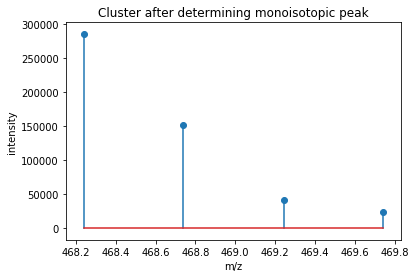

In [154]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.stem(cluster_df.loc[minimum_error_mono_index:].mz_centroid, cluster_df.loc[minimum_error_mono_index:].summed_intensity)
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.margins(0.06)
plt.title('Cluster after determining monoisotopic peak')
plt.show()

In [155]:
cluster_df

,peak_id,mz_centroid,summed_intensity
0,3,467.749297,111599
1,1,468.240632,285440
2,2,468.739658,151536
3,4,469.243980,41969
4,6,469.740474,23782


In [156]:
expected_spacing

0.5016775

In [157]:
cluster_df['mz_mod'] = cluster_df.mz_centroid - ((cluster_df.peak_id-1)*expected_spacing)

In [158]:
cluster_df

,peak_id,mz_centroid,summed_intensity,mz_mod
0,3,467.749297,111599,466.745942
1,1,468.240632,285440,468.240632
2,2,468.739658,151536,468.237980
3,4,469.243980,41969,467.738947
4,6,469.740474,23782,467.232086


In [159]:
cluster_mz_centroid = wavg(cluster_df, "mz_mod", "summed_intensity")
cluster_mz_centroid

467.89513447622244

In [160]:
cluster_summed_intensity = cluster_df.summed_intensity.sum()
cluster_summed_intensity

614326

In [161]:
monoisotopic_mass = (cluster_mz_centroid - PROTON_MASS) * charge_state
monoisotopic_mass

933.7757169524449

In [162]:
feature_df

,feature_id,base_frame_id,base_cluster_id,charge_state,start_frame,end_frame,quality_score,summed_intensity,scan_lower,scan_upper,mz_lower,mz_upper
0,53359,1416,205,2,1406,1429,1.0,632901,142,157,467.257751,469.746613


In [163]:
FRAMES_PER_SECOND = 2
retention_time_secs = feature_df.loc[0].base_frame_id / FRAMES_PER_SECOND
retention_time_secs

708.0

In [164]:
pairs_df = ms2_peaks_df[['centroid_mz', 'intensity']].copy().sort_values(by=['intensity'], ascending=False)
pairs_df

,centroid_mz,intensity
0,718.368,653767
1,553.287,352998
7,850.428,329756
4,719.371,311185
5,717.402,268438
120,850.409,213526
6,618.334,210925
2,552.954,177481
8,699.423,174802
3,251.119,174699


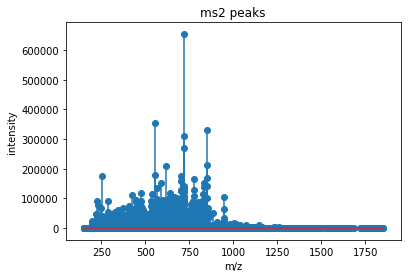

In [165]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.stem(pairs_df.centroid_mz, pairs_df.intensity)
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.margins(0.06)
plt.title('ms2 peaks')
plt.show()

In [166]:
from pyteomics import mgf
import os

MGF_FILE_NAME = "/Users/darylwilding-mcbride/Documents/random-features.mgf"

spectra = []

# Write out the spectrum
spectrum = {}
spectrum["m/z array"] = pairs_df.centroid_mz.values
spectrum["intensity array"] = pairs_df.intensity.values
params = {}
params["TITLE"] = "Feature {}".format(feature_df.loc[0].feature_id.astype(int))
params["INSTRUMENT"] = "Bruker timsTOF Pro"
params["PEPMASS"] = "{} {}".format(monoisotopic_mass, cluster_summed_intensity)
params["CHARGE"] = "1+"
params["RTINSECONDS"] = "{}".format(retention_time_secs)
params["SCANS"] = "{}-{}".format(feature_df.loc[0].scan_lower.astype(int), feature_df.loc[0].scan_upper.astype(int))
spectrum["params"] = params
spectra.append(spectrum)

# Write out the MGF file
if os.path.isfile(MGF_FILE_NAME):
    os.remove(MGF_FILE_NAME)
mgf.write(output=MGF_FILE_NAME, spectra=spectra)

In [188]:
# parse the Hardklor output to create the search MGF
# see https://proteome.gs.washington.edu/software/hardklor/docs/hardklorresults.html
HK_FILE_NAME = "/Users/darylwilding-mcbride/Documents/hk/Hela_20A_20R_500-feature-59-correlation-0.6.hk"
hk_results_df = pd.read_table(HK_FILE_NAME, skiprows=1, header=None, names=['monoisotopic_mass','charge','intensity','base_isotope_peak','analysis_window','deprecated','modifications','correlation'])
hk_results_df

,monoisotopic_mass,charge,intensity,base_isotope_peak,analysis_window,deprecated,modifications,correlation
P,198.1707,1,1992875,199.178,199.0380-201.4580,0.0,_,0.9991
P,198.1867,1,30038,199.194,199.0380-201.4580,0.0,_,0.9944
P,398.1354,2,2743,200.075,199.7980-201.4580,0.0,_,0.9922
P,204.0887,1,25592,205.096,204.0650-208.0950,0.0,_,0.9009
P,208.1557,1,17497,209.163,208.9710-211.5000,0.0,_,0.9948
P,215.1027,1,12702,216.110,216.0000-218.2460,0.0,_,0.9782
P,226.1657,1,3827736,227.173,227.0090-229.3990,0.0,_,0.9997
P,226.1687,1,403023,227.176,227.0090-229.3990,0.0,_,0.9970
P,227.1657,1,263041,228.173,228.0040-230.3720,0.0,_,0.9997
P,227.8167,1,298,228.824,228.7150-230.9690,0.0,_,0.9531


In [168]:
charge_state

2

In [171]:
ms2_features_df = hk_results_df[['monoisotopic_mass', 'intensity']].copy().sort_values(by=['monoisotopic_mass'], ascending=True)
ms2_features_df

,monoisotopic_mass,intensity
P,185.2687,65
P,201.0147,633
P,208.0827,21337
P,220.0787,11059
P,221.0787,3487
P,222.0977,43451
P,223.0200,750
P,224.1847,674
P,228.1217,26598
P,229.1187,39601


In [180]:
from pyteomics import mgf
import os

SEARCH_MGF_FILE_NAME = "/Users/darylwilding-mcbride/Documents/random-features-search.mgf"

spectra = []

# Write out the spectrum
spectrum = {}
spectrum["m/z array"] = ms2_features_df.monoisotopic_mass.values
spectrum["intensity array"] = ms2_features_df.intensity.values
params = {}
params["TITLE"] = "{}, feature {}, correlation {}, model error {:.2f}, sulphurs {}".format(CONVERTED_DATABASE_NAME, FEATURE_ID, MINIMUM_CORRELATION, minimum_error, minimum_error_sulphur)
params["INSTRUMENT"] = "Bruker timsTOF Pro"
params["PEPMASS"] = "{} {}".format(monoisotopic_mass, cluster_summed_intensity)
params["CHARGE"] = "1+"
params["RTINSECONDS"] = "{}".format(retention_time_secs)
params["SCANS"] = "{}-{}".format(feature_df.loc[0].scan_lower.astype(int), feature_df.loc[0].scan_upper.astype(int))
spectrum["params"] = params
spectra.append(spectrum)

# Write out the MGF file
if os.path.isfile(SEARCH_MGF_FILE_NAME):
    os.remove(SEARCH_MGF_FILE_NAME)
mgf.write(output=SEARCH_MGF_FILE_NAME, spectra=spectra)

In [185]:
TEST_MGF_FILE_NAME = '/Users/darylwilding-mcbride/Documents/test.mgf'

# Write out the spectrum
spectra = []
spectrum = {}
spectrum["m/z array"] = np.empty(0)
spectrum["intensity array"] = np.empty(0)
params = {}
params["TITLE"] = "{}, feature {}, correlation {}, model error {:.2f}, sulphurs {}".format(CONVERTED_DATABASE_NAME, FEATURE_ID, MINIMUM_CORRELATION, minimum_error, minimum_error_sulphur)
params["INSTRUMENT"] = "Bruker timsTOF Pro"
params["PEPMASS"] = "{} {}".format(monoisotopic_mass, cluster_summed_intensity)
params["CHARGE"] = "1+"
params["RTINSECONDS"] = "{}".format(retention_time_secs)
params["SCANS"] = "{}-{}".format(feature_df.loc[0].scan_lower.astype(int), feature_df.loc[0].scan_upper.astype(int))
spectrum["params"] = params
spectra.append(spectrum)

# Write out the MGF file
if os.path.isfile(TEST_MGF_FILE_NAME):
    os.remove(TEST_MGF_FILE_NAME)
mgf.write(output=TEST_MGF_FILE_NAME, spectra=spectra)

In [216]:
header_filename = '/Users/darylwilding-mcbride/Documents/mgf_headers/Hela_20A_20R_500-feature-1048-correlation-0.6.txt'
with open(header_filename) as f:
    content = f.readlines()

In [191]:
content[0]

'BEGIN IONS\n'

In [192]:
hk_filename = '/Users/darylwilding-mcbride/Documents/hk/Hela_20A_20R_500-feature-1048-correlation-0.6.hk'
hk_results_df = pd.read_table(hk_filename, skiprows=1, header=None, names=['monoisotopic_mass','charge','intensity','base_isotope_peak','analysis_window','deprecated','modifications','correlation'])
fragments_df = hk_results_df[['monoisotopic_mass', 'intensity']].copy().sort_values(by=['monoisotopic_mass'], ascending=True)
fragments_df.monoisotopic_mass += PROTON_MASS  # the monoisotopic_mass from Hardklor is the zero charge M, so we add the proton mass to get M+H


In [193]:
fragments_df

,monoisotopic_mass,intensity
P,184.765976,44
P,192.132976,319
P,197.125976,127834
P,201.084976,41698
P,205.060976,2271
P,213.084976,75040
P,213.157976,62655
P,214.099276,15070
P,214.152976,197190
P,215.956976,328


In [204]:
fragments = []
for row in fragments_df.iterrows():
    index, data = row
    fragments.append("{} {}\n".format(data.monoisotopic_mass, data.intensity.astype(int)))

In [205]:
fragments

['184.765976 44\n',
 '192.13297599999999 319\n',
 '197.12597599999998 127834\n',
 '201.08497599999998 41698\n',
 '205.06097599999998 2271\n',
 '213.08497599999998 75040\n',
 '213.157976 62655\n',
 '214.099276 15070\n',
 '214.152976 197190\n',
 '215.956976 328\n',
 '217.136976 134264\n',
 '217.188276 213\n',
 '219.07797599999998 29017\n',
 '223.152976 138627\n',
 '225.12097599999998 99612\n',
 '226.338976 22\n',
 '226.866976 205\n',
 '229.115976 102269\n',
 '230.118476 8191\n',
 '230.118476 8082\n',
 '233.129276 39959\n',
 '234.121976 84623\n',
 '242.075176 11639\n',
 '242.147976 165678\n',
 '245.128976 151460\n',
 '246.17897599999998 64615\n',
 '249.18597599999998 864\n',
 '260.156976 6893\n',
 '261.153976 81590\n',
 '262.11697599999997 41725\n',
 '262.14797599999997 74650\n',
 '266.158276 34913\n',
 '266.163276 12477\n',
 '268.619176 2170\n',
 '272.982976 472\n',
 '273.146976 10044\n',
 '274.850976 161\n',
 '278.107976 22240\n',
 '278.112976 50346\n',
 '281.84297599999996 896\n',
 '28

In [206]:
content

['BEGIN IONS\n',
 'CHARGE=2+\n',
 'SCANS=140-155\n',
 'PEPMASS=525.1820533075595 12132154\n',
 'INSTRUMENT=Bruker timsTOF Pro\n',
 'TITLE=feature 1048, file Hela_20A_20R_500, correlation 0.6, model error 0.00, sulphurs 0\n',
 'RTINSECONDS=67.5\n',
 'END IONS\n',
 '\n']

In [219]:
content = content[:-1]

In [208]:
content

['BEGIN IONS\n',
 'CHARGE=2+\n',
 'SCANS=140-155\n',
 'PEPMASS=525.1820533075595 12132154\n',
 'INSTRUMENT=Bruker timsTOF Pro\n',
 'TITLE=feature 1048, file Hela_20A_20R_500, correlation 0.6, model error 0.00, sulphurs 0\n',
 'RTINSECONDS=67.5\n',
 'END IONS\n']

In [212]:
content[(len(content)-1):(len(content)-1)] = fragments

In [213]:
content

['BEGIN IONS\n',
 'CHARGE=2+\n',
 'SCANS=140-155\n',
 'PEPMASS=525.1820533075595 12132154\n',
 'INSTRUMENT=Bruker timsTOF Pro\n',
 'TITLE=feature 1048, file Hela_20A_20R_500, correlation 0.6, model error 0.00, sulphurs 0\n',
 'RTINSECONDS=67.5\n',
 ['184.765976 44\n',
  '192.13297599999999 319\n',
  '197.12597599999998 127834\n',
  '201.08497599999998 41698\n',
  '205.06097599999998 2271\n',
  '213.08497599999998 75040\n',
  '213.157976 62655\n',
  '214.099276 15070\n',
  '214.152976 197190\n',
  '215.956976 328\n',
  '217.136976 134264\n',
  '217.188276 213\n',
  '219.07797599999998 29017\n',
  '223.152976 138627\n',
  '225.12097599999998 99612\n',
  '226.338976 22\n',
  '226.866976 205\n',
  '229.115976 102269\n',
  '230.118476 8191\n',
  '230.118476 8082\n',
  '233.129276 39959\n',
  '234.121976 84623\n',
  '242.075176 11639\n',
  '242.147976 165678\n',
  '245.128976 151460\n',
  '246.17897599999998 64615\n',
  '249.18597599999998 864\n',
  '260.156976 6893\n',
  '261.153976 81590\n

In [220]:
with open('/Users/darylwilding-mcbride/Documents/test.mgf', 'w') as file_handler:
    for item in content[:len(content)-1]:
        file_handler.write("{}".format(item))
    for item in fragments:
        file_handler.write("{}".format(item))
    for item in content[len(content)-1:]:
        file_handler.write("{}".format(item))